# Tweet Sentiment Extraction

This notebook was developed for the competition: [Tweet Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction)

## What this model will try to predict?

It's attempting to predict the word or phrase from the tweet that exemplifies the provided sentiment. The word or phrase should include all characters within that span (i.e. including commas, spaces, etc.). See an example below:

```
{
    "text": "Sooo SAD I will miss you here in San Diego!!!",
    "selected_text": "Sooo SAD",
    "sentiment": "negative"
}
```

The objective it's find `selected_text` as **"Soo SAD"** in `text` **"Sooo SAD I will miss you here in San Diego!!!"**

### How it's will be evaluate?

The metric in this competition is the [word-level Jaccard score](https://en.wikipedia.org/wiki/Jaccard_index). A good description of Jaccard similarity for strings is [here](https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50).

A Python implementation based on the links above, and matched with the output of the C# implementation on the back end, is provided below.

```
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))
```

---

## Proposed solution

We'll apply RoBERTa model (by [ai.facebook](https://ai.facebook.com/)) with Tensor Flow to solve this problem. It's one of *state of the art* for natural language processing today.

[RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) is based on Google's BERT model released in 2018.

You can see below the scores os RoBERTa compared with others ensembles:

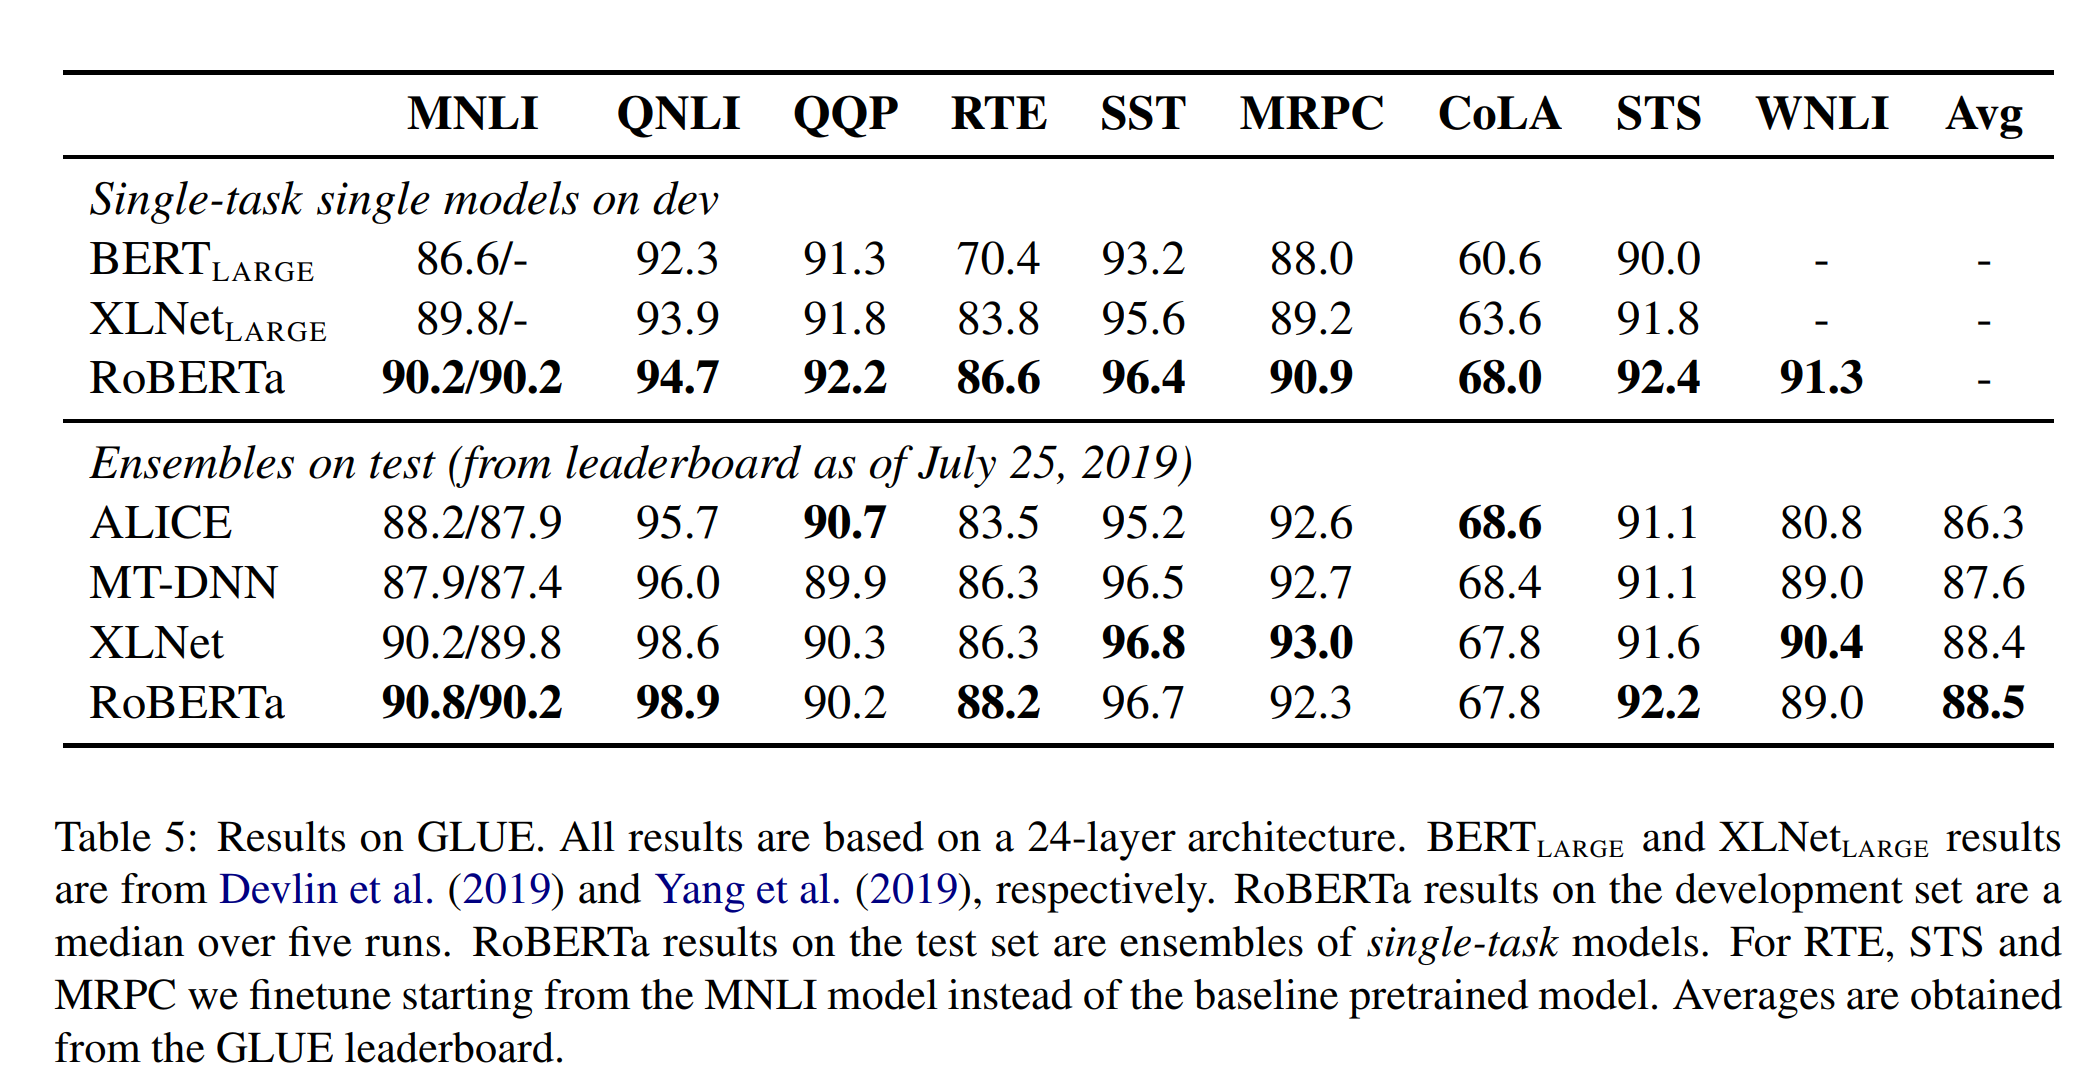

---

## Architecture

![](https://trello-attachments.s3.amazonaws.com/5d93d97e715aba7c97fde8f7/5ea0ee2bfc245456c9f29a81/5a070a62be29775d1b7f5dfdfbef4059/tweet_sentiment_extraction.png)

---

## References

- [TensorFlow roBERTa - \[0.705\] | Kaggle](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705/)
- [transformers 2.8.0 documentation](https://huggingface.co/transformers/)


# 1. Modeling

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.backend as K
import torch
import transformers
import tokenizers
from tqdm import tqdm
import pickle
import time
from sklearn.base import BaseEstimator
from sklearn.model_selection import ParameterGrid
import json

tf.random.set_seed(1234)

class SentenceSelector(BaseEstimator):
    def __init__(self, maxlen=96, bert_path="/kaggle/input/tf-roberta", epochs=3, batch_size=32, learning_rate=3e-5,
                 optimizer="adam", validation_split=0.2, ignore_neutrals=True, verbose=False):
        self.verbose = verbose
        self.maxlen = maxlen
        self.bert_path = bert_path
        self.bert_vocab = self.bert_path + "/vocab-roberta-base.json"
        self.bert_merges = self.bert_path + "/merges-roberta-base.txt"
        self.bert_config = self.bert_path + "/config-roberta-base.json"
        self.bert_pretrained = self.bert_path + "/pretrained-roberta-base.h5"
        self.tokenizer = tokenizers.ByteLevelBPETokenizer(vocab_file=self.bert_vocab,merges_file=self.bert_merges,
                                                           lowercase=True, add_prefix_space=True)
        self.model = None
        self.epochs = epochs
        self.batch_size = batch_size 
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.validation_split = validation_split
        self.ignore_neutrals = ignore_neutrals
        self.sentiment_col = "sentiment"
        self.text_col = "text"
        self.sentiment_dict = {"positive": self.tokenizer.encode("positive").ids[0],
                                "negative": self.tokenizer.encode("negative").ids[0],
                                "neutral": self.tokenizer.encode("neutral").ids[0]}
        
    def fit(self, X, y):
        
        # Gambis master for neutral texts
        if self.ignore_neutrals == True:
            X_temp = X.to_dict(orient="records")
            X_new = []
            y_new = []
            for i in range(len(X_temp)):
                if X_temp[i][self.sentiment_col] != "neutral":
                    X_new.append(X_temp[i])
                    y_new.append(y[i])
            X = pd.DataFrame(X_new)
            y = pd.Series(y_new)
            
        if isinstance(X, pd.DataFrame):           
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values      
            
        input_ids, attention_mask, token_type_ids, start_tokens, end_tokens = self._preprocessing_train(X, y)

        K.clear_session()
        model = self._build_model()

        model.fit(x=[input_ids, attention_mask, token_type_ids], y=[start_tokens, end_tokens],
                  epochs=self.epochs, batch_size=self.batch_size, verbose=1, validation_split=self.validation_split)

        self.model = model

    def _build_model(self):
        ids = tf.keras.layers.Input((self.maxlen,), dtype=tf.int32)
        att = tf.keras.layers.Input((self.maxlen,), dtype=tf.int32)
        tok = tf.keras.layers.Input((self.maxlen,), dtype=tf.int32)
        
        if self.optimizer.lower() == "rmsprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        else:
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        config = transformers.RobertaConfig.from_pretrained(self.bert_config)
        bert_model = transformers.TFRobertaModel.from_pretrained(self.bert_pretrained, config=config)
        x = bert_model(ids,attention_mask=att,token_type_ids=tok)

        x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
        x1 = tf.keras.layers.Conv1D(128, 2,padding='same')(x1)
        x1 = tf.keras.layers.LeakyReLU()(x1)
        x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
        x1 = tf.keras.layers.Dense(1)(x1)
        x1 = tf.keras.layers.Flatten()(x1)
        x1 = tf.keras.layers.Activation('softmax')(x1)

        x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
        x2 = tf.keras.layers.Conv1D(128, 2, padding='same')(x2)
        x2 = tf.keras.layers.LeakyReLU()(x2)
        x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
        x2 = tf.keras.layers.Dense(1)(x2)
        x2 = tf.keras.layers.Flatten()(x2)
        x2 = tf.keras.layers.Activation('softmax')(x2)

        model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
        model.compile(loss="binary_crossentropy", optimizer=optimizer)
        return model
        
    def _preprocessing_train(self, X, y):            
        input_ids = np.ones((X.shape[0], self.maxlen), dtype="int32")
        attention_mask = np.zeros((X.shape[0], self.maxlen), dtype="int32")
        token_type_ids = np.zeros((X.shape[0], self.maxlen), dtype="int32")
        start_tokens = np.zeros((X.shape[0], self.maxlen), dtype="int32")
        end_tokens = np.zeros((X.shape[0], self.maxlen), dtype="int32")
        
        for k in range(X.shape[0]):
            text1 = " " + " ".join(X[k][0].split())
            text2 = " ".join(y[k].split())
            idx = text1.find(text2)
            chars = np.zeros((len(text1)))
            chars[idx:idx + len(text2)] = 1
            if text1[idx-1] == ' ':
                chars[idx-1] = 1 

            enc = self.tokenizer.encode(text1) 

            offsets = []; idx = 0
            for t in enc.ids:
                w = self.tokenizer.decode([t])
                offsets.append((idx,idx+len(w)))
                idx += len(w)

            toks = []
            for i,(a,b) in enumerate(offsets):
                sm = np.sum(chars[a:b])
                if sm>0: toks.append(i) 

            s_tok = self.sentiment_dict[X[k][1]]
            input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
            attention_mask[k,:len(enc.ids)+5] = 1

            if len(toks)>0:
                start_tokens[k,toks[0]+1] = 1
                end_tokens[k,toks[-1]+1] = 1

        return input_ids, attention_mask, token_type_ids, start_tokens, end_tokens

    def _preprocessing_test(self, X):            
        input_ids = np.ones((X.shape[0], self.maxlen),dtype="int32")
        attention_mask = np.zeros((X.shape[0], self.maxlen),dtype="int32")
        token_type_ids = np.zeros((X.shape[0], self.maxlen),dtype="int32")
        
        for k in range(X.shape[0]):
            text1 = " "+" ".join(X[k][0].split())
            enc = self.tokenizer.encode(text1)                
            s_tok = self.sentiment_dict[X[k][1]]
            input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
            attention_mask[k,:len(enc.ids)+5] = 1
            
        return input_ids, attention_mask, token_type_ids

    def score(self, X_test, y_test):
        if self.model == None:
            raise AttributeError('The model is not trained yet.')
            
        # Gambis master for neutral text
        if self.ignore_neutrals == True:
            preds = self._predict_ignore_neutrals(X_test)
        else:
            preds = self.predict(X_test)
            
        scores = []
        
        for pred, true in zip(preds, y_test):
            score = self.jaccard(pred, true)
            scores.append(score)
            
        return np.mean(scores)
    
    def jaccard(self, str1, str2):
        "The same score function of the competition with only an added of try except to avoid error when we have empty strings."
        a = set(str1.lower().split()) 
        b = set(str2.lower().split())
        c = a.intersection(b)

        try:
            jaccard_score = float(len(c)) / (len(a) + len(b) - len(c))
        except Exception as e:
            print("An error occurred when compute jaccard score:", e)
            jaccard_score = float(0)
        finally:
            return jaccard_score
    
    def predict(self, X):
        if self.model == None:
            raise AttributeError('The model is not trained yet.') 
            
        # Gambis master for neutral texts
        if self.ignore_neutrals == True:
            return self._predict_ignore_neutrals(X)
        
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        input_ids, attention_mask, token_type_ids = self._preprocessing_test(X)
        
        preds = self.model.predict([input_ids, attention_mask, token_type_ids])
        
        selected_text = []
        for k in range(X.shape[0]):
            start = np.argmax(preds[0][k,])
            end = np.argmax(preds[1][k,])
            
            if start > end: 
                text = X[k][0]
            else:
                text = " "+" ".join(X[k][0].split())
                enc = self.tokenizer.encode(text)
                text = self.tokenizer.decode(enc.ids[start-1:end])
                
            selected_text.append(text)

        return selected_text

    def _predict_ignore_neutrals(self, X):
        if self.model == None:
            raise AttributeError('The model is not trained yet.')
        
        X.reset_index(drop=True, inplace=True)
        
        selected_text = []
        for each in range(len(X)):
            if X[self.sentiment_col][each] == "neutral":
                selected_text.append(X[self.text_col][each])
            else:
                X_temp = X.loc[each]
                X_temp = X_temp[[self.text_col, self.sentiment_col]]
                X_temp = np.array([X_temp.values])
                input_ids, attention_mask, token_type_ids = self._preprocessing_test(X_temp)
                preds = self.model.predict([input_ids, attention_mask, token_type_ids])
                for k in range(X_temp.shape[0]):
                    start = np.argmax(preds[0][k,])
                    end = np.argmax(preds[1][k,])

                    if start > end: 
                        text = X_temp[k][0]
                    else:
                        text = " "+" ".join(X_temp[k][0].split())
                        enc = self.tokenizer.encode(text)
                        text = self.tokenizer.decode(enc.ids[start-1:end])

                    selected_text.append(text)

        return selected_text
    
    def save_model(self, filepath):
        if self.model == None:
            raise AttributeError('The model is not trained yet.')     
        tf.keras.models.save_model(self.model, filepath)
    
    def load_model(self, filepath, force=False):
        if self.model != None and force == False:
            raise AttributeError('You already have a loaded model. If you want to reload inform the parameter force=True')
        self.model = tf.keras.models.load_model(filepath)
        
###########################################

def GridSearch(param_grid, X_train, y_train, X_test, y_test, train_size=None, test_size=None, log_scores=False, verbose=False):
    if isinstance(train_size, float):
        x1, x2, y1, y2 = train_test_split(X_train, y_train, train_size=train_size, random_state=42, stratify=X_train["sentiment"])
        if verbose:
            print("train dataset reduced from {} to {} rows".format(len(X_train), len(x1)))
        X_train = x1.copy()
        y_train = y1.copy()
    if isinstance(test_size, float):
        x1, x2, y1, y2 = train_test_split(X_test, y_test, test_size=test_size, random_state=42, stratify=X_test["sentiment"])
        if verbose:
            print("test dataset reduced from {} to {} rows".format(len(X_test), len(x2)))
        X_test = x2.copy()
        y_test = y2.copy()

    param_grid = list(ParameterGrid(param_grid))
    if verbose:
        print("The param_grid will result in {} fits.".format(len(param_grid)))
        
    scores = []
    best_score = 0
    best_param = None
    
    exec_counter = 0
    for params in param_grid:
        exec_counter += 1
        if verbose:
            print("{}/{}".format(exec_counter, len(param_grid)))
        model = SentenceSelector()
        model.set_params(**params)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores.append({"score": score, "params": model.get_params()})

    for each in scores:
        if each["score"] > best_score:
            best_score = each["score"]
            best_param = each["params"]

    if log_scores:
        with open('gridsearch_scores_log.json', 'w') as outfile:
            json.dump(scores, outfile)
        
    result = {"score": best_score, "params": best_param}
    if verbose:
        print(result)
    return result

def input_files(data_map, tpu=False):
    if tpu:
        kaggle = KaggleDatasets()
        for dataset in data_map.keys():
            GCS_DS_PATH = KaggleDatasets().get_gcs_path(dataset)
            if isinstance(data_map.get(dataset), str):
                data_map[dataset] = GCS_DS_PATH
            if isinstance(data_map.get(dataset), dict):
                for file in data_map[dataset].keys():
                    data_map[dataset][file] = GCS_DS_PATH + "/" + data_map[dataset][file]
    else:
        for dataset in data_map.keys():
            if isinstance(data_map.get(dataset), str):
                data_map[dataset] = "/kaggle/input/{}".format(data_map[dataset])
            if isinstance(data_map.get(dataset), dict):
                for file in data_map[dataset].keys():
                    data_map[dataset][file] = "/kaggle/input/{}/{}".format(dataset, data_map[dataset][file])
    return data_map

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    tpu_on = True
    !pip install gcsfs
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    tpu_on = False

if tpu_on:
    from kaggle_datasets import KaggleDatasets
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

In [ ]:
data_map = {
    "tweet-sentiment-extraction": {
        "train": "train.csv",
        "test": "test.csv",
        "submission": "sample_submission.csv"
    },
    "tf-roberta": "tf-roberta/"
}
    
files = input_files(data_map, tpu=tpu_on)
files

# 2. Load and prepare dataset

## 2.1 Load train dataset

In [ ]:
df_train = pd.read_csv(files["tweet-sentiment-extraction"]["train"])
df_train.fillna('', inplace=True)
print(df_train.shape)
df_train.head()

## 2.2 Split in X and y

In [ ]:
X = df_train.drop(columns=["textID", "selected_text"])
y = df_train["selected_text"].values

In [ ]:
print("The biggest sentence has {} characteres.".format(max([len(each) for each in X["text"]])))

## 2.3 Split in train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=X["sentiment"])

print("train:", len(X_train))
print("test:", len(X_test))

# 3. Execution

In [ ]:
parameters = {
    "maxlen": 141,
    "epochs": 3,
    "batch_size": 32,
    "learning_rate": 3e-5,
    "validation_split": 0.2,
    "optimizer": "adam",
    "ignore_neutrals": False,
    "bert_path": files["tf-roberta"],
    "model_filepath": "model.sav",
    "GridSearch": False,
    "ParameterGrid": {
        "maxlen": [96, 141],
        "epochs": [3, 4, 5],
        "batch_size": [16, 32],
        "learning_rate": [2e-5, 3e-5, 5e-5],
        "ignore_neutrals": [True, False],
        "optimizer": ["adam"],
        "verbose": [True],
        "validation_split": [0.2],
        "bert_path": [files["tf-roberta"]]
    }
}

In [ ]:
if parameters["GridSearch"]:
    gridsearch = GridSearch(parameters["ParameterGrid"], X_train, y_train, X_test, y_test, train_size=0.3, test_size=0.1, log_scores=True, verbose=True)
    model = SentenceSelector()
    model.set_params(**gridsearch["params"])
else:
    model = SentenceSelector(maxlen=parameters["maxlen"], epochs=parameters["epochs"], batch_size=parameters["batch_size"],
                         ignore_neutrals=parameters["ignore_neutrals"], learning_rate=parameters["learning_rate"],
                         optimizer=parameters["optimizer"], validation_split=parameters["validation_split"])

model.fit(X_train, y_train)
model.save_model(parameters["model_filepath"])

In [ ]:
model.get_params()

# 4. Validation

We'll make the validation in two steps. First in the **training set** and then, in the **testing set**.

## 4.1 Validation - training set

This is a good sanity check if the model is working and has high enough capacity to fit the training data.

In [ ]:
train_val = X_train.copy()
train_val["true_selected_text"] = y_train
train_val = train_val.to_dict(orient="records")
lst = []

with tqdm(total=len(train_val)) as pbar:
    for each in train_val:
        each["selected_text"] = model.predict(pd.DataFrame([each]))[0]
        each["score"] = model.jaccard(each["true_selected_text"], each["selected_text"])
        lst.append(each)
        pbar.update(1)
    
train_val = pd.DataFrame(lst)
score = train_val["score"].mean()

print("\n Score (training set): {}".format(score))

### 4.1.1 Error analysis (training set) - Sentiment

In [ ]:
train_val.groupby("sentiment").mean().plot(kind="bar", rot=1);

train_val.groupby("sentiment").mean()

## 4.2 Validation - testing set



In [ ]:
test_val = X_test.copy()
test_val["true_selected_text"] = y_test
test_val = test_val.to_dict(orient="records")
lst = []

with tqdm(total=len(test_val)) as pbar:
    for each in test_val:
        each["selected_text"] = model.predict(pd.DataFrame([each]))[0]
        each["score"] = model.jaccard(each["true_selected_text"], each["selected_text"])
        lst.append(each)
        pbar.update(1)
    
test_val = pd.DataFrame(lst)
score = test_val["score"].mean()

print("Score (testing set): {}".format(score))

### 4.2.1 Error analysis (testing set) - Sentiment

In [ ]:
# Error analysis - Sentiment
test_val.groupby("sentiment").mean().plot(kind="bar", rot=1);

test_val.groupby("sentiment").mean()

### 4.2.2 Error analysis (testing set) - Top 20 worst scores

In [ ]:
test_val.sort_values(by="score", ascending=True).head(20)

### 4.2.3 Error analysis (testing set) - Top 20 best scores

In [ ]:
test_val.sort_values(by="score", ascending=False).head(20)

# 5. Load submission files

In [ ]:
df_test = pd.read_csv(files["tweet-sentiment-extraction"]["test"])
df_test.fillna('', inplace=True)
print(df_test.shape)
df_test.head()

In [ ]:
df_test["selected_text"] = model.predict(df_test[["text", "sentiment"]])

In [ ]:
df_sub = pd.read_csv(files["tweet-sentiment-extraction"]["submission"])
df_sub.fillna('', inplace=True)
print(df_sub.shape)
df_sub.head()

In [ ]:
df_sub = df_sub.merge(df_test, on="textID")
df_sub.drop(columns=["selected_text_x", "text", "sentiment"], errors="ignore", inplace=True)
df_sub.columns = ["textID", "selected_text"]
df_sub

In [ ]:
df_sub.to_csv("submission.csv", index=False)